In [ ]:
# libraries and functions to be used

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 256)        

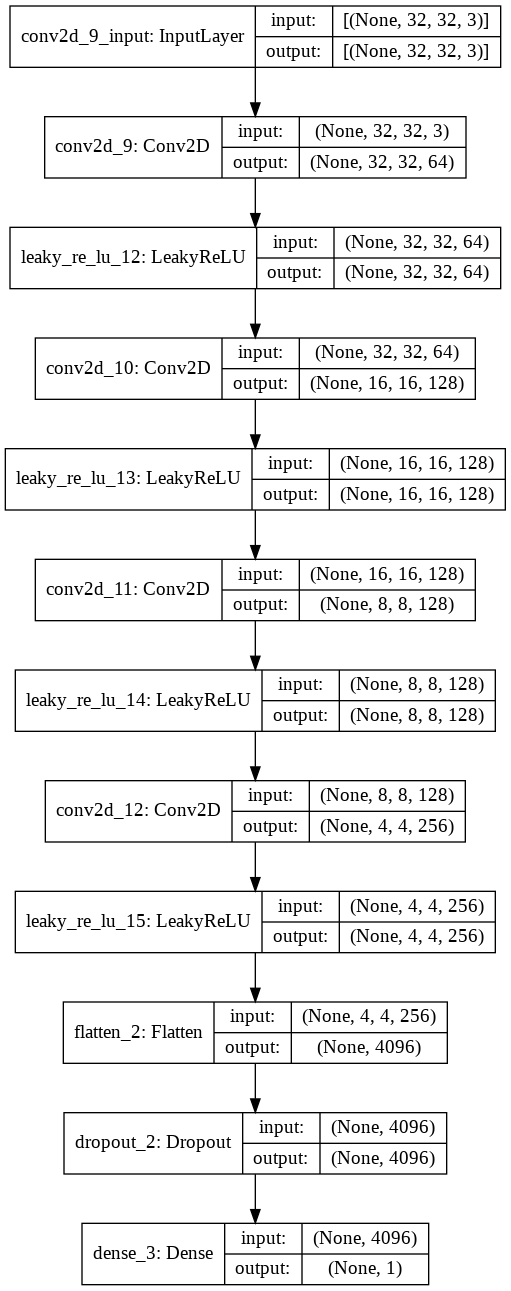

In [ ]:
# discriminator model

d_model = Sequential()

d_model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
d_model.add(LeakyReLU(alpha=0.2))

d_model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
d_model.add(LeakyReLU(alpha=0.2))

d_model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
d_model.add(LeakyReLU(alpha=0.2))

d_model.add(Conv2D(256, (4,4), strides=(2,2), padding='same'))
d_model.add(LeakyReLU(alpha=0.2))

d_model.add(Flatten())
d_model.add(Dropout(0.4))
d_model.add(Dense(1, activation='sigmoid'))

# Adam optimizer with learning_rate=0.0002 and momentum=0.5
opt = Adam(learning_rate=0.0002, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

d_model.summary()

plot_model(d_model, to_file='d_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 128)      

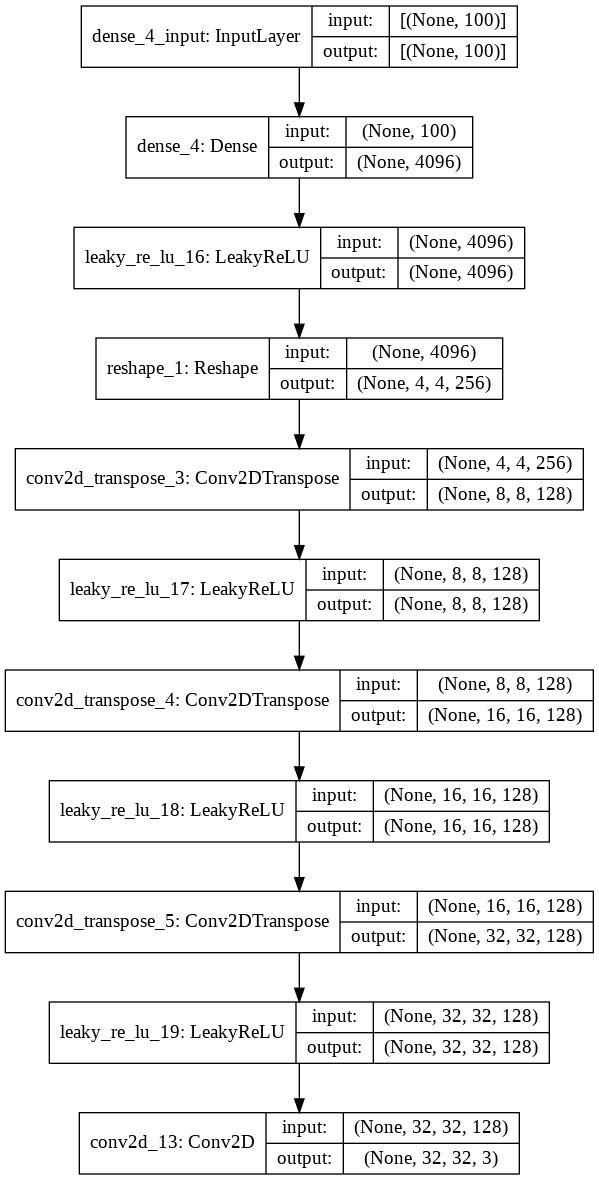

In [ ]:
# generator model

g_model = Sequential()

g_model.add(Dense(256 * 4 * 4, input_dim=100))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(Reshape((4, 4, 256)))

g_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g_model.add(LeakyReLU(alpha=0.2))

g_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g_model.add(LeakyReLU(alpha=0.2))

g_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
g_model.add(LeakyReLU(alpha=0.2))

g_model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

g_model.summary()

plot_model(g_model, to_file='g_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 923905    
Total params: 2,390,020
Trainable params: 1,466,115
Non-trainable params: 923,905
_________________________________________________________________


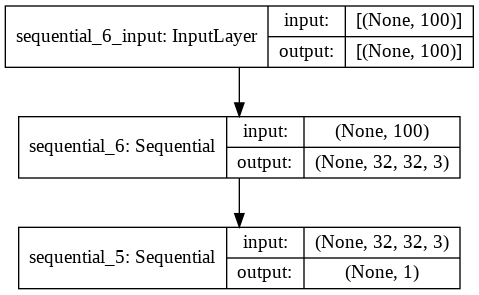

In [ ]:
# gan model

d_model.trainable = False   # preventing the discriminator from being trained within gan

gan_model = Sequential()

gan_model.add(g_model)

gan_model.add(d_model)

# Adam optimizer with learning rate = 0.0002 and momentum = 0.5 is used
opt = Adam(learning_rate=0.0002, beta_1=0.5)

gan_model.compile(loss='binary_crossentropy', optimizer=opt)

gan_model.summary()

plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# function to load and preprocess data

def load_dataset():

	(X, _), (_, _) = load_data()

	X = X.astype('float32')
 
 # X is scaled to the range [-1, 1]

	X = (X - 127.5) / 127.5

	return X

In [ ]:
# function to return n random images from the dataset

def generate_real_images(dataset, n):

	i = randint(0, dataset.shape[0], n)

	X = dataset[i]

  # assign real labels (1) to the images

	y = ones((n, 1))
 
	return X, y

In [ ]:
# function to generate n random points in the latent space (dimension 100)

def generate_latent_points(n):

	x = randn(100 * n).reshape((n,100))
 
	return x


# function to generate n fake images using latent points and the generator

def generate_fake_images(g_model, n):

	x_input = generate_latent_points(n)

	X = g_model.predict(x_input)

  # assign fake labels (0) to the images

	y = zeros((n, 1))
 
	return X, y

In [ ]:
# function to plot 5 images after 10 epochs and save them for comparison

def save_plot(images, epoch):

  # images are scaled to [0,1] from [-1, 1]

	images = (images + 1) / 2.0

	for i in range(5):

		pyplot.subplot(5, 1, 1 + i)

		pyplot.axis('off')

		pyplot.imshow(images[i])

	name = 'image' + str(epoch) + '.png'
	pyplot.savefig(name)
	pyplot.close()
 
# function to evaluate model performance on 150 images after 10 epochs and to save the generator model

def evaluate(epoch, g_model, d_model, dataset, n=150):

	X_real, y_real = generate_real_images(dataset, n)

	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

	x_fake, y_fake = generate_fake_images(g_model, n)

	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

	print(f'Accuracy real: {acc_real*100:.2f}%, fake: {acc_fake*100:.2f}%')

	save_plot(x_fake, epoch)

	name = 'generator' + str(epoch) + '.h5'
	g_model.save(name)
 

In [ ]:
# training the gan model

dataset = load_dataset()

n_epochs = 200

batch_size = 128

batch_per_epoch = int(dataset.shape[0]/batch_size)
h = int(batch_size/2)

for i in range(n_epochs):

		for j in range(batch_per_epoch):

      # discriminator is trained on a half batch of real images 

			X_real, y_real = generate_real_images(dataset, h)

      # discriminator is trained on a half batch of fake images

			d_loss1, _ = d_model.train_on_batch(X_real, y_real)

			X_fake, y_fake = generate_fake_images(g_model, h)

			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

			X_gan = generate_latent_points(batch_size)

			y_gan = ones((batch_size, 1))

      # gan is trained on a full batch of fake images but with real labels (1) to get correct gradient

			g_loss = gan_model.train_on_batch(X_gan, y_gan)

			print(f'{i+1}, {j+1}/{batch_per_epoch}, d1={d_loss1:.3f}, d2={d_loss2:.3f} g={g_loss:.3f}')

    # for every 10th epoch, evaluate and save model

		if (i+1) % 10 == 0:
			evaluate(i, g_model, d_model, dataset)



Streaming output truncated to the last 5000 lines.
78, 255/390, d1=0.521, d2=0.632 g=1.263
78, 256/390, d1=0.603, d2=0.482 g=1.250
78, 257/390, d1=0.488, d2=0.452 g=1.256
78, 258/390, d1=0.538, d2=0.510 g=1.275
78, 259/390, d1=0.479, d2=0.594 g=1.247
78, 260/390, d1=0.629, d2=0.557 g=1.263
78, 261/390, d1=0.558, d2=0.618 g=1.314
78, 262/390, d1=0.513, d2=0.447 g=1.238
78, 263/390, d1=0.631, d2=0.502 g=1.167
78, 264/390, d1=0.550, d2=0.569 g=1.281
78, 265/390, d1=0.481, d2=0.464 g=1.308
78, 266/390, d1=0.490, d2=0.501 g=1.228
78, 267/390, d1=0.589, d2=0.543 g=1.224
78, 268/390, d1=0.517, d2=0.541 g=1.190
78, 269/390, d1=0.535, d2=0.480 g=1.134
78, 270/390, d1=0.536, d2=0.581 g=1.284
78, 271/390, d1=0.617, d2=0.564 g=1.217
78, 272/390, d1=0.725, d2=0.602 g=1.309
78, 273/390, d1=0.628, d2=0.532 g=1.036
78, 274/390, d1=0.577, d2=0.638 g=1.219
78, 275/390, d1=0.595, d2=0.538 g=1.263
78, 276/390, d1=0.605, d2=0.533 g=1.234
78, 277/390, d1=0.648, d2=0.533 g=1.214
78, 278/390, d1=0.544, d2=0.5